In [1]:
import predict
import cv2
import numpy
from matplotlib import pyplot as plt
import math

model_name = "../resource/v7-LandCover-retrained-twice"
input_image_filename = "kaka_input.tif"

map_top_left_coords = (0,100)
map_bottom_right_coords = (100,0)

polygons = [
    ((10, 10), (10,20), (40, 10)),
    ((35, 35), (45, 45), (35, 55), (25, 45))
]

map_grid_cell_size = (10, 10)


2023-06-15 19:05:37.347436: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-15 19:05:37.929764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-15 19:05:37.929840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-15 19:05:37.929846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2023-06-15 19:05:39.268464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karpase/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-15 19:05:39.268533: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Some helpful variables




In [2]:
minx = min(map_top_left_coords[0], map_bottom_right_coords[0])
maxx = max(map_top_left_coords[0], map_bottom_right_coords[0])
sizex = maxx - minx

miny = min(map_top_left_coords[1], map_bottom_right_coords[1])
maxy = max(map_top_left_coords[1], map_bottom_right_coords[1])
sizey = maxy - miny

## Load the NN model

In [3]:
model = predict.load_model(model_name)


## Load the input Map

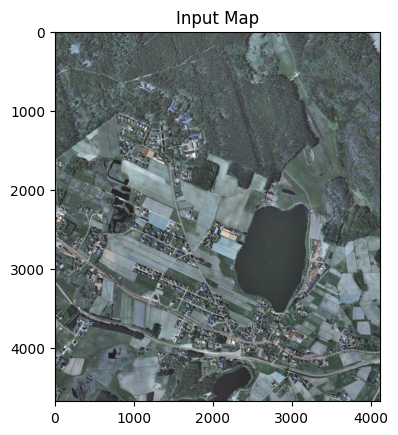

In [4]:
image = cv2.imread(input_image_filename)

plt.imshow(image)
plt.title('Input Map')
plt.show()

## Predict the cover labels


In [5]:
pred, output_image = predict.image_to_pixel_cover(model, image)


Splitting files into  /tmp/tmpo0y4iurk
3/3 [==============================] - 5s 1s/step


## Show the cover labels


* black - Background
* red - building
* green - woodland
* blue - water
* white - road


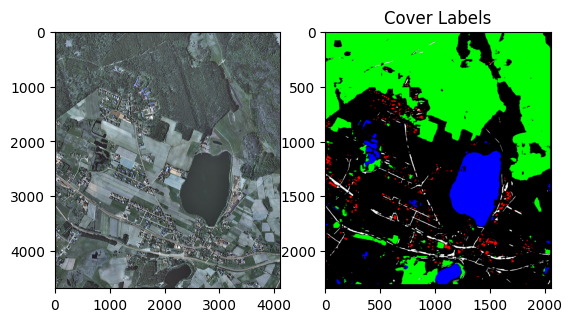

In [6]:
fig, (m1, m2) = plt.subplots(1,2)
plt.title('Cover Labels')
m1.imshow(image)
m2.imshow(output_image)


## Add the Polygons to the Cover Labels

Each polygon gets a unique color


<class 'numpy.ndarray'> (2339, 2056) uint8 [[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[(10, 90), (10, 80), (40, 90)]
[(35, 65), (45, 55), (35, 45), (25, 55)]
[[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0.5, 1.0, 'Map with Polygons')

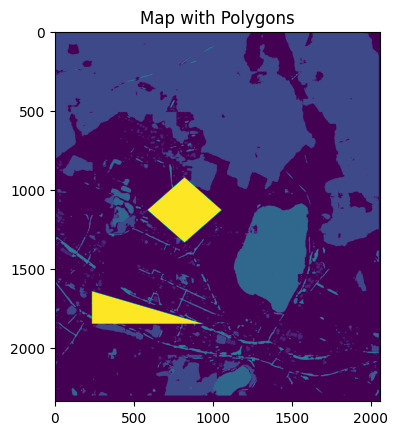

In [23]:
pred = pred.astype(numpy.uint8)

def flip_coords(point):
    x,y = point
    return x, miny + sizey - y

def coords_to_relative_position(point):
    x,y = point
    rx = (x - minx) / sizex
    ry = (y - miny) / sizey
    return rx, ry

def relative_position_to_pixel(rpoint, image):
    rx, ry = rpoint
    x = round(image.shape[0] * rx)
    y = round(image.shape[1] * ry)
    return numpy.array([x,y],dtype=numpy.int32)

polygon_id = predict.NUM_CLASSES + 1

for p in polygons:        
    polyshape = numpy.array(list(map(lambda x: relative_position_to_pixel(coords_to_relative_position(flip_coords(x)), pred), p)))
    polyshape = polyshape.reshape((-1, 1, 2))
    cv2.fillPoly(pred, [polyshape], polygon_id)
    polygon_id = polygon_id + 1

print(pred)    

plt.imshow(pred)
plt.title('Map with Polygons')    



## Overlay a Grid


(2339, 2056)
delta:  206 234


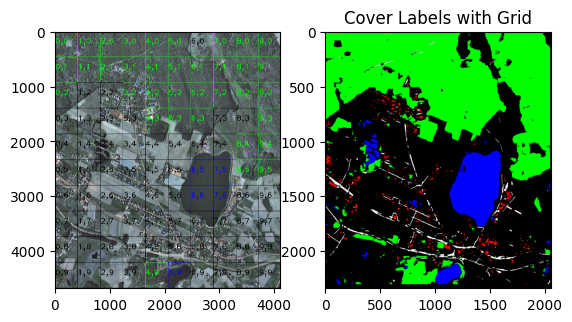

In [24]:
image = cv2.imread(input_image_filename)


grid = predict.pixel_labels_to_grid(pred, minx, miny, maxx, maxy, map_grid_cell_size[0], map_grid_cell_size[1])
for i,j in grid:
    x1, y1, x2, y2, histogram = grid[i,j]
    amax = numpy.argmax(histogram)
    color = tuple(map(int, predict.palette[amax]))
    cv2.rectangle(image, (x1*2, y1*2), (x2*2, y2*2), color, 5)
    cv2.putText(image, str(i) + "," + str(j), (x1*2, y1+y2), cv2.FONT_HERSHEY_PLAIN, 10, color, 10, cv2.LINE_AA)


fig, (m1, m2) = plt.subplots(1,2)
plt.title('Cover Labels with Grid')
m1.imshow(image)
m2.imshow(output_image)
